# Single-Task Test

In [1]:
#install the right fvgp version
#!pip install fvgp~=4.7.6

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP
import time
from distributed import Client
client = Client()

%load_ext autoreload
%autoreload 2

/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39795 instead
  warnings.warn(


In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data

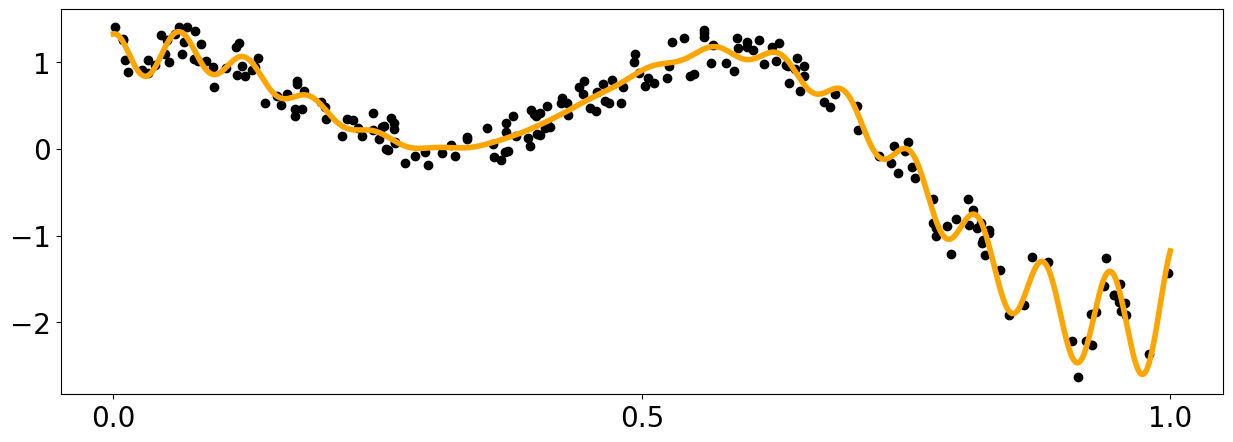

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
#np.random.seed(42)
x_data = np.random.rand(200).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing a Gaussian Process

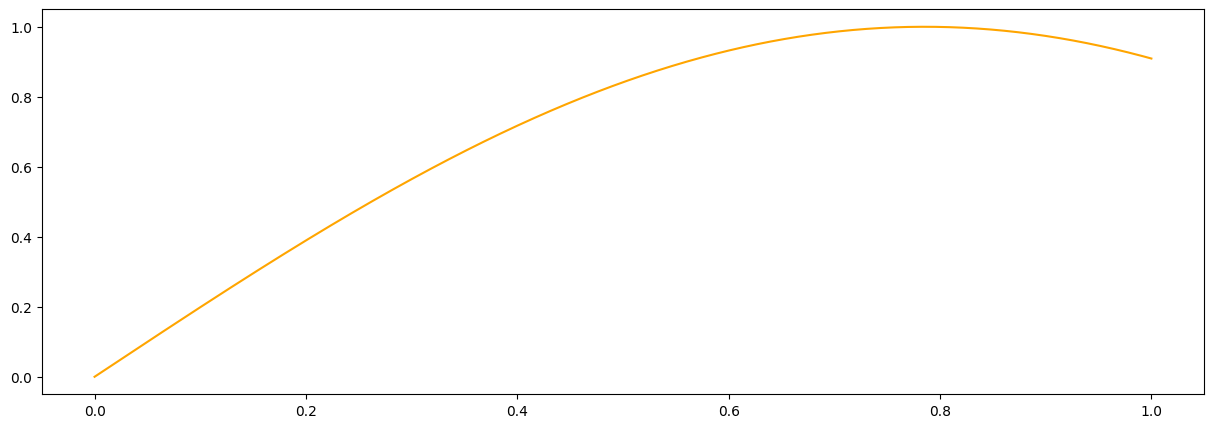

In [5]:
from fvgp.kernels import *
from scipy import sparse
def my_noise(x,hps):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise can be a vector, a matrix, or a sparse matrix in case gp2Scale is used.  
    return np.zeros(len(x)) + hps[2]

#stationary
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])

#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and different training options

In [6]:
st = time.time()
from loguru import logger
logger.disable("fvgp")
my_gp1 = GP(x_data,y_data,
            init_hyperparameters = np.ones((2))/10.,  # we need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.1, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            #kernel_function=skernel, 
            kernel_function_grad=None, 
            #prior_mean_function=meanf, 
            prior_mean_function_grad=None,
            #noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=True,
            )


hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       #[0.001,0.1],  #noise
                       #[0.01,1.]  #mean
                      ])
#my_gp1.update_gp_data(x_data, y_data, noise_variances_new=np.ones(y_data.shape) * 0.05) #this is just for testing, not needed
print("Standard Training (MCMC)")
hps = my_gp1.train(hyperparameter_bounds=hps_bounds, info = True, max_iter = 100)
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")

print("ADAM")
hps = my_gp1.train(hyperparameter_bounds=hps_bounds, info = True, max_iter = 100, method="adam")
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")

print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global', max_iter = 20)
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")

print("Local Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")

print("HGDL Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=2, dask_client=client)
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")

Standard Training (MCMC)
Starting likelihood. f(x)=  -41.6886650390137
Finished  10  out of  100  iterations. f(x)=  -41.6886650390137
Finished  20  out of  100  iterations. f(x)=  -18.55389878892322
Finished  30  out of  100  iterations. f(x)=  -17.402047311032476
Finished  40  out of  100  iterations. f(x)=  -17.82400800315827
Finished  50  out of  100  iterations. f(x)=  -17.82400800315827
Finished  60  out of  100  iterations. f(x)=  -21.41533318862355
Finished  70  out of  100  iterations. f(x)=  -19.656195987920853
Finished  80  out of  100  iterations. f(x)=  -22.11478475888984
Finished  90  out of  100  iterations. f(x)=  -19.157194626995903
Result= [2.47967079 0.38695908] after  0.08517813682556152  seconds

ADAM
Result= [2.81090579 0.34234067] after  5.089747667312622  seconds

Global Training
Result= [2.81090579 0.34234067] after  5.781603813171387  seconds

Local Training
Result= [2.81090579 0.34234067] after  6.301860332489014  seconds

HGDL Training
Result= [2.81090579 0.

In [7]:
#You can always test your gradient like this before running local optimizers
my_gp1.test_log_likelihood_gradient(my_gp1.hyperparameters, epsilon=1e-6)

(array([ 0.00960691, -0.09447507]), array([ -2.50400981, -42.83222641]))

### More advanced: Asynchronous training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different training runs on different computers.
This training will continue without any signs of life until you query  the solution via 'update_hyperparameters(object)' or call 'my_gp1.stop_training(opt_obj)'

In [8]:
my_gp1.set_hyperparameters(np.array([1,1]))

In [9]:
print(my_gp1.hyperparameters)
opt_obj = my_gp1.train(hyperparameter_bounds=hps_bounds, dask_client=client, asynchronous=True, method='hgdl')

[1 1]


In [10]:
# The result won't change much (or at all) since this is such a simple optimization
for i in range(20):
    time.sleep(0.1)
    print("iteration ", i)
    my_gp1.update_hyperparameters(opt_obj)
    print(my_gp1.hyperparameters)

iteration  0
[1 1]
iteration  1
[1 1]


/home/marcus/Coding/fvGP/fvgp/gp.py:725: UserWarning: Hyperparameter update not successful len(optima list) = 0
  hps = self.trainer.update_hyperparameters(opt_obj)


iteration  2
[1 1]
iteration  3
[1 1]
iteration  4
[1 1]
iteration  5
[1 1]
iteration  6
[1 1]
iteration  7
[1 1]
iteration  8
[1.32701196 0.35157603]
iteration  9
[1.32701196 0.35157603]
iteration  10
[1.32701196 0.35157603]
iteration  11
[1.32701196 0.35157603]
iteration  12
[1.32701196 0.35157603]
iteration  13
[1.32701196 0.35157603]
iteration  14
[1.32701196 0.35157603]
iteration  15
[1.32701196 0.35157603]
iteration  16
[1.32701196 0.35157603]
iteration  17
[1.32701196 0.35157603]
iteration  18
[1.32701196 0.35157603]
iteration  19
[1.32701196 0.35157603]


In [11]:
my_gp1.stop_training(opt_obj) ##this leaves the dask client alive, kill_client() will shut it down. 

## The Result

Posterior Mean and Uncertainty


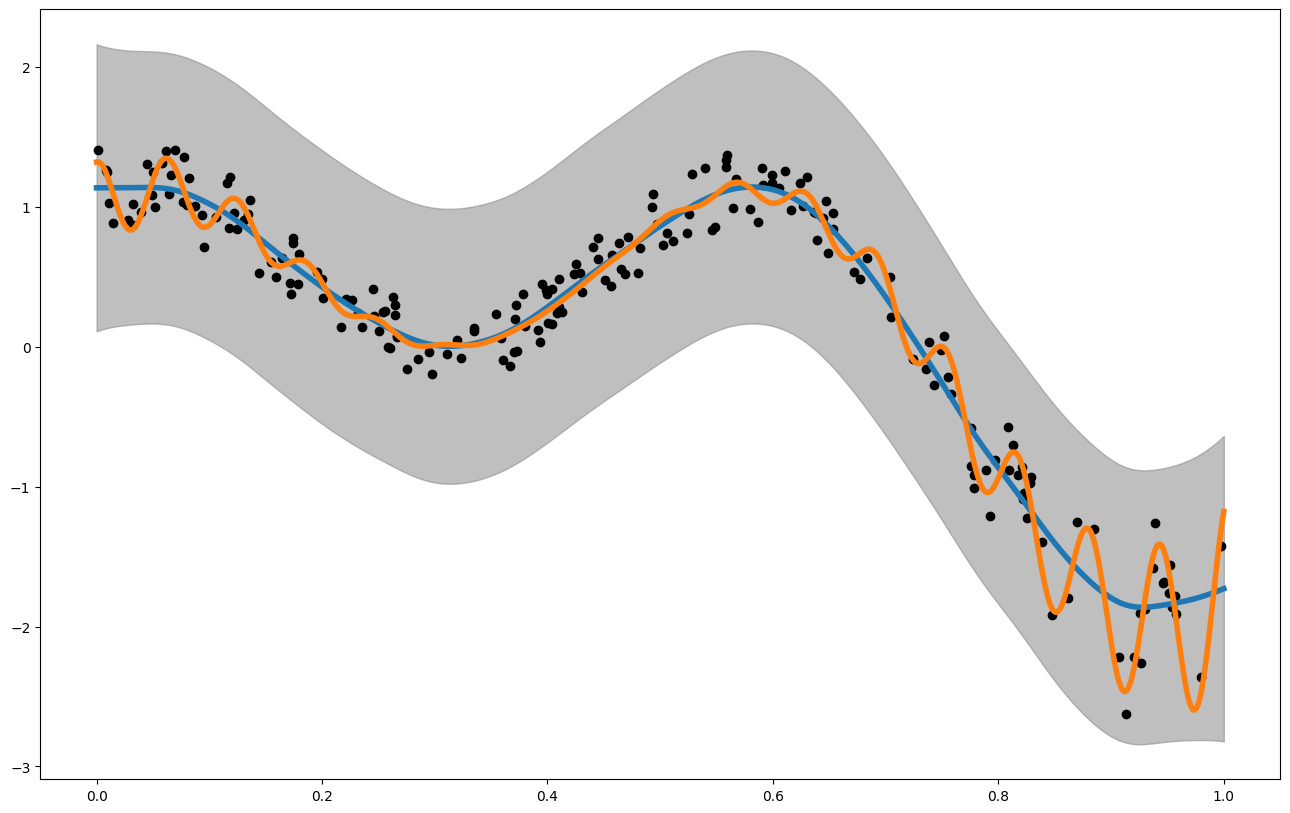

Posterior Mean Gradient


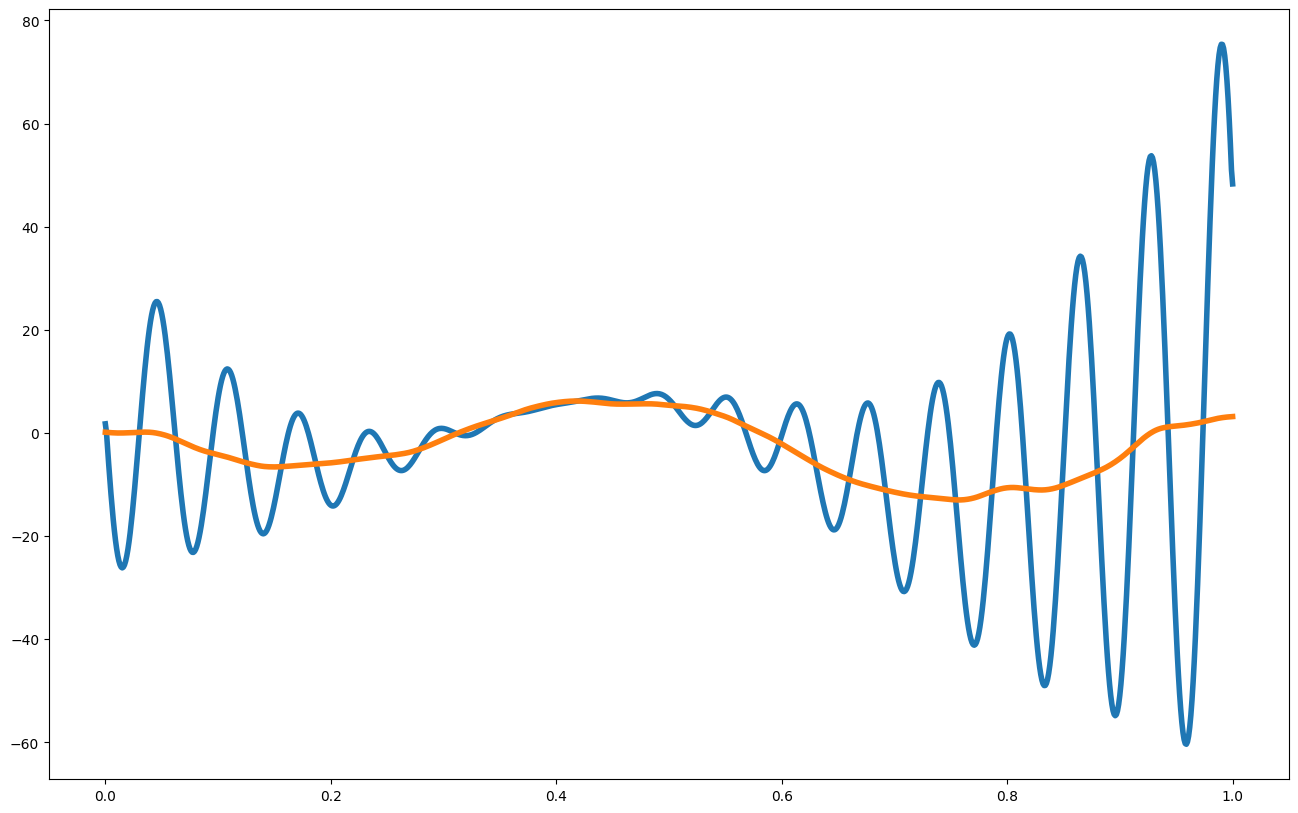

RMSE:              0.19308380092476982
CRPS (mean, std):  (np.float64(0.09940742265920068), np.float64(0.13188791021837065))
R2:                0.9649827817279077
NLPD:              0.6311875648507348


In [12]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)


# different ways to call 
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=False)["v(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
mean_grad = my_gp1.posterior_mean_grad(x_pred.reshape(-1,1), direction=0)["dm/dx"]

print("Posterior Mean and Uncertainty")
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(my_gp1.x_data,my_gp1.y_data, color = 'black')
plt.show()

print("Posterior Mean Gradient")
plt.figure(figsize = (16,10))
dx = 1./len(x_pred)
plt.plot(x_pred1D,np.gradient(f1(x_pred1D).flatten(), dx), label = "ground truth gradient", linewidth = 4)
plt.plot(x_pred1D,mean_grad, label = "posterior mean grad", linewidth = 4)
plt.show()



##looking at some validation metrics
print("RMSE:             ",my_gp1.rmse(x_pred1D,f1(x_pred1D).flatten()))
print("CRPS (mean, std): ",my_gp1.crps(x_pred1D,f1(x_pred1D).flatten()))
print("R2:               ",my_gp1.r2(x_pred1D,f1(x_pred1D).flatten()))
print("NLPD:             ",my_gp1.nlpd(x_pred1D,f1(x_pred1D).flatten()))

## Predicted Information Gain

In [13]:
relative_entropy =  my_gp1.gp_relative_information_entropy_set(x_pred.reshape(-1,1))["RIE"]

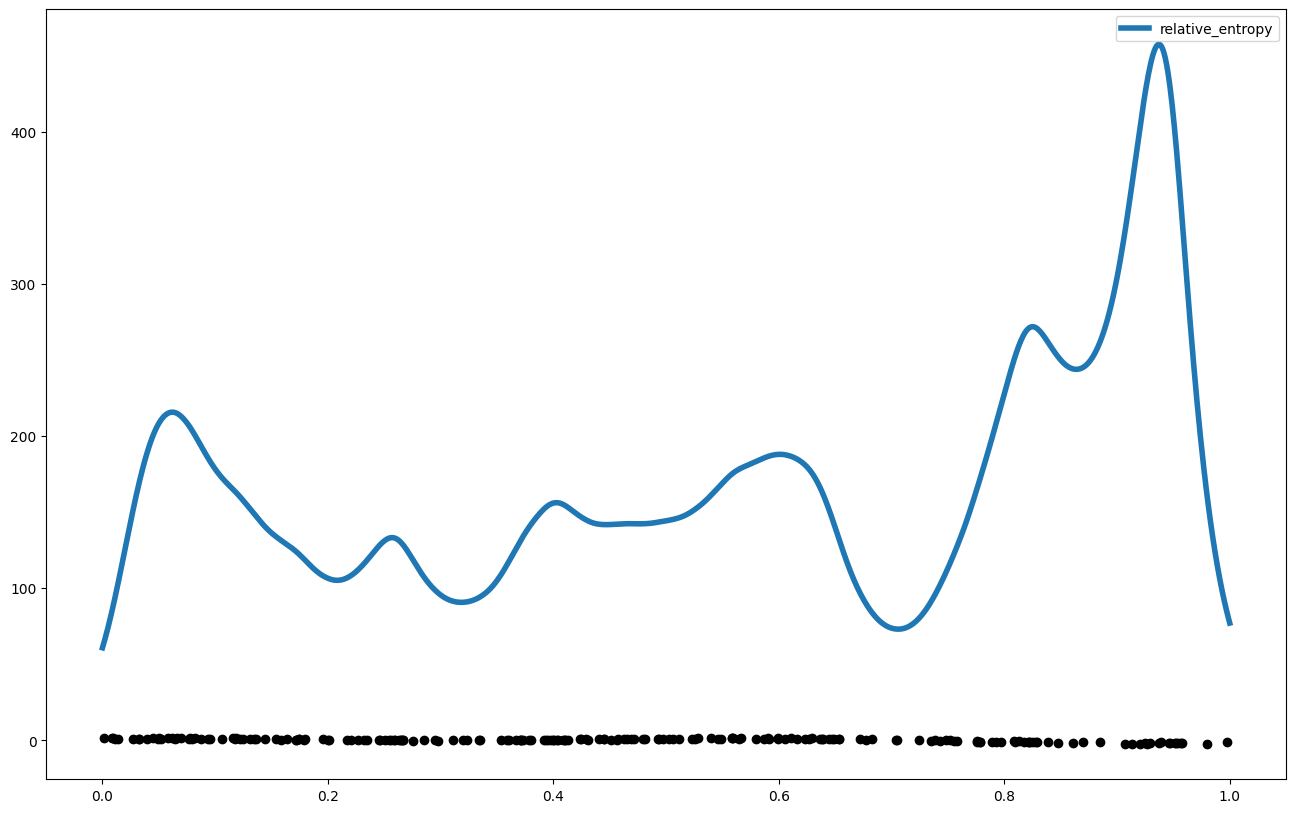

In [14]:
plt.figure(figsize = (16,10))
plt.plot(x_pred,relative_entropy, label = "relative_entropy", linewidth = 4)
plt.scatter(x_data,y_data, color = 'black')
plt.legend()

In [15]:
#We can ask mutual information and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print("MI: ",my_gp1.gp_mutual_information(x_test))
print("TC: ",my_gp1.gp_total_correlation(x_test))
my_gp1.gp_entropy(x_test)
my_gp1.gp_entropy_grad(x_test, 0)
my_gp1.gp_kl_div(x_test, np.ones((len(x_test))), np.identity((len(x_test))))
my_gp1.gp_relative_information_entropy(x_test)
my_gp1.gp_relative_information_entropy_set(x_test)
my_gp1.posterior_covariance(x_test)
my_gp1.posterior_covariance_grad(x_test)
my_gp1.posterior_mean(x_test)
my_gp1.posterior_mean_grad(x_test)
my_gp1.posterior_probability(x_test, np.ones((len(x_test))), np.identity((len(x_test))))

MI:  {'x': array([[0.45],
       [0.45]]), 'mutual information': np.float64(7.635515945498582)}
TC:  {'x': array([[0.45],
       [0.45]]), 'total correlation': np.float64(17.792040379789782)}


{'mu': array([0.62433549, 0.62433549]),
 'covariance': array([[0.09501505, 0.00410595],
        [0.00410595, 0.09501505]]),
 'probability': np.float64(0.12314711587994445)}

## Running many GPs at once in parallel

In [20]:
#duplicate data: in practice, this would be different data in every column
y_data = np.broadcast_to(y_data[:, None], (y_data.size, 10))

my_gp1 = GP(x_data,y_data,
            init_hyperparameters = np.ones((2))/10.,  # we need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape[0]) * 0.1, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu',
            )


hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                      ])

print("Standard Training (MCMC)")
hps = my_gp1.train(hyperparameter_bounds=hps_bounds, info = True, max_iter = 100)
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")


Standard Training (MCMC)
Starting likelihood. f(x)=  -41.68866503901373
Finished  10  out of  100  iterations. f(x)=  -25.075478550082465
Finished  20  out of  100  iterations. f(x)=  -18.36341022342569
Finished  30  out of  100  iterations. f(x)=  -18.36341022342569
Finished  40  out of  100  iterations. f(x)=  -17.324150221042288
Finished  50  out of  100  iterations. f(x)=  -17.354008726057174
Finished  60  out of  100  iterations. f(x)=  -20.93839371760984
Finished  70  out of  100  iterations. f(x)=  -20.93839371760984
Finished  80  out of  100  iterations. f(x)=  -18.394468493949404
Finished  90  out of  100  iterations. f(x)=  -17.660626837767296
Result= [2.82103125 0.38444457] after  236.97394514083862  seconds



In [26]:
x_pred = np.linspace(0,1,1000).reshape(1000,1)
mean = my_gp1.posterior_mean(x_pred)["m(x)"]
sd   = np.sqrt(my_gp1.posterior_covariance(x_pred)["v(x)"])

Posterior Means and Uncertainties


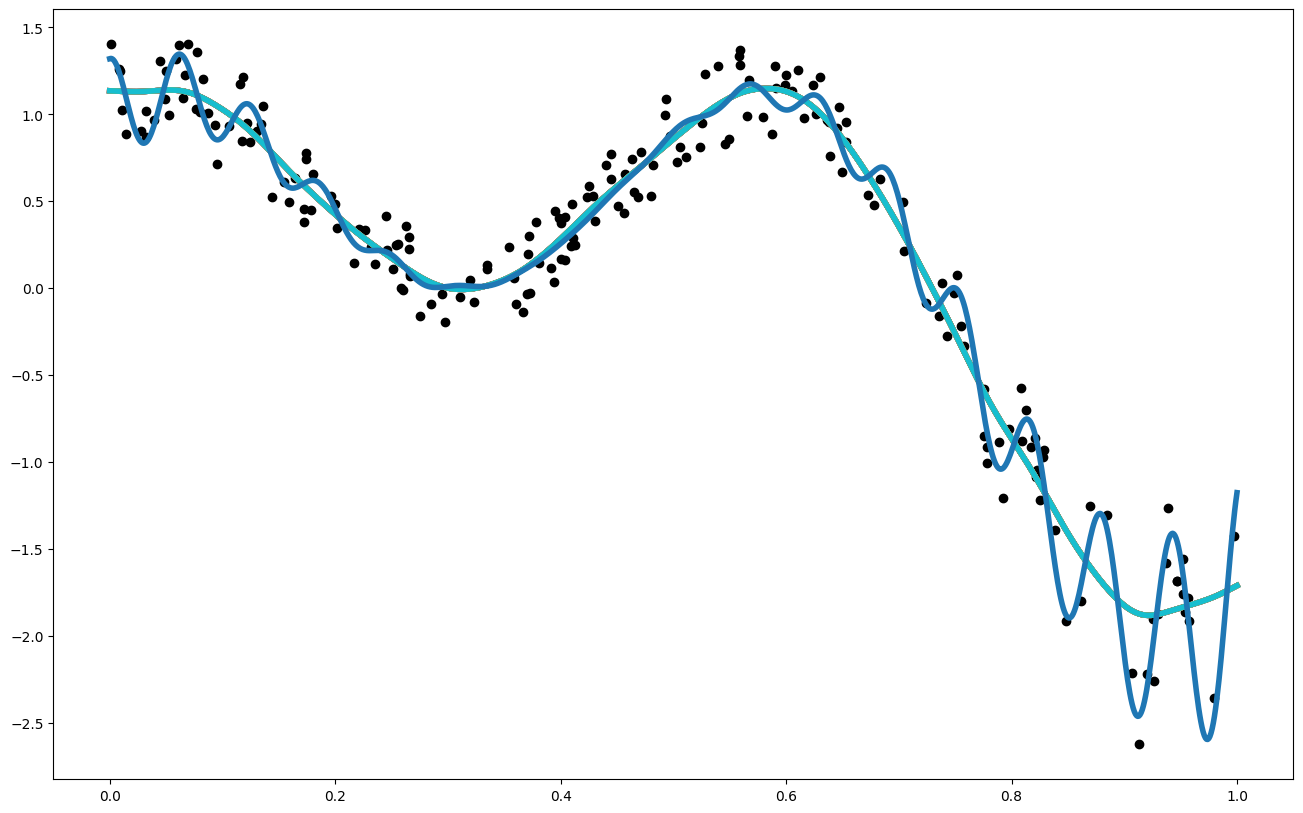

In [38]:
print("Posterior Means and Uncertainties")
plt.figure(figsize = (16,10))
for i in range(10):
    plt.plot(x_pred.flatten(),mean[:,i], label = "posterior mean", linewidth = 4)
plt.scatter(my_gp1.x_data,my_gp1.y_data[:,0], color = 'black')
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.show()